# 고양이 얼굴 바운딩 박스 찾기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### 1.데이터 준비

In [3]:
!gdown  https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb

Downloading...
From: https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb
To: /content/BBRegression.zip
100% 945k/945k [00:00<00:00, 90.3MB/s]


In [ ]:
!unzip BBRegression.zip

In [5]:
IMAGE_PATH = '/content/BBRegression'

In [6]:
import glob
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


In [7]:
import os

FILE_NAME = 'label_cats.csv'

csv_path = os.path.join(IMAGE_PATH, 'train')
xml_df = xml_to_csv(csv_path)

In [8]:
xml_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-228_jpg.rf.eb6e6c9bef4948fc0ef34fa69bfeec1...,224,224,cat,40,2,105,70
1,cat-133_jpg.rf.f28aa24b4ef0b965447ef52fb739f23...,224,224,cat,53,2,140,112
2,cat-181_jpg.rf.e09964d5292e4128ef99db46b0b352c...,224,224,cat,47,9,207,125
3,cat-122_jpg.rf.f191c6eca98a6d3a361d47722a29bf8...,224,224,cat,84,3,209,102
4,cat-269_jpg.rf.86974c2fb78b7470205d358c53f7055...,224,224,cat,96,3,200,85


In [10]:
images = xml_df['filename'].values
images[:5]

array(['cat-228_jpg.rf.eb6e6c9bef4948fc0ef34fa69bfeec18.jpg',
       'cat-133_jpg.rf.f28aa24b4ef0b965447ef52fb739f233.jpg',
       'cat-181_jpg.rf.e09964d5292e4128ef99db46b0b352c7.jpg',
       'cat-122_jpg.rf.f191c6eca98a6d3a361d47722a29bf8f.jpg',
       'cat-269_jpg.rf.86974c2fb78b7470205d358c53f7055b.jpg'],
      dtype=object)

In [11]:
points = xml_df.iloc[:, 4:].values
points[:5]

array([[ 40,   2, 105,  70],
       [ 53,   2, 140, 112],
       [ 47,   9, 207, 125],
       [ 84,   3, 209, 102],
       [ 96,   3, 200,  85]])

- 시각화

In [12]:
import PIL

dataset_images = []
dataset_bbs = []

for file, point in zip(images, points):
    f = os.path.join(IMAGE_PATH, 'train', file)
    image = PIL.Image.open(f)
    arr = np.array(image)
    dataset_images.append(arr)
    dataset_bbs.append(point)


In [16]:
dataset_bbs = np.array(dataset_bbs)
dataset_images = np.array(dataset_images)

In [17]:
dataset_images.shape

(91, 224, 224, 3)

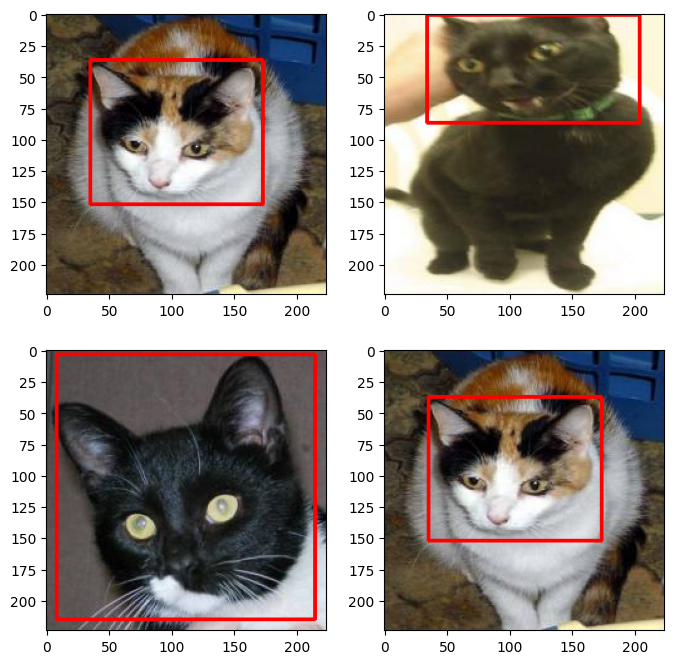

In [18]:
import cv2

samples = np.random.randint(91, size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = dataset_bbs[idx].reshape(2, 2)
    img = cv2.rectangle(dataset_images[idx].copy(),
                        tuple(points[0]),
                        tuple(points[1]),
                        color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()


In [19]:
# 중간 처리 이미지 데이터 저장

np.savez('cat_bbs.npz',
         images=dataset_images,
         bbs=dataset_bbs
         )

In [20]:
# npz 파일 읽어오기

dataset = np.load('cat_bbs.npz')

In [21]:
X = dataset['images']
y = dataset['bbs']

X.shape, y.shape

((91, 224, 224, 3), (91, 4))

In [22]:
X_train = X.copy()
y_train = y.copy()

In [ ]:
X_train_s = X_train.astype('float32')/255.

### 2.모델만들기

In [23]:
from keras.applications import MobileNetV2

base = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
# base.summary()

In [26]:
from keras import layers

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4)
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10294788 (39.27 MB)
Trainable params: 8036804 (30.66 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [28]:
model.compile(
    optimizer = 'adam',
    loss='mse',
    metrics=['mse']
)